### 参数设置
- 设备，路径等

In [1]:
DEVICE = 'cuda:3'
DATASET = 'eprstmt'
model_path = '../models/chatglm2/'
path_to_data = '/workspace/ChatGLM2_test/data/demo1'

### 读取模型
- 这里使用了全精度模型
- 也可以使用int4,int8或半精度模型

In [2]:
import torch
from transformers import  AutoModel,AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(model_path,trust_remote_code=True).bfloat16().cuda(DEVICE)

/opt/conda/envs/chatglm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


### 准备模板
- 告诉模型应该怎么给出正确的回复
- 之前的回复、提示、模板会以对话的形式，存在his/history中

In [3]:
# define a basic prompt for express comment
# prompt template with 4shots ahead

prompt = """文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

这个产品的质量真的很出色！ ->  好评
使用起来非常流畅，没有任何问题。 ->  好评
它的功能非常强大，帮助我轻松完成任务。 ->  好评
超级友好和专业的客服团队。 ->  好评
物流速度快，让我很惊喜。 ->  好评
包装得很仔细，确保了商品的安全。 ->  好评
这个价格真是太划算了！ ->  好评

购买后不久，产品就出现了严重的问题，无法正常使用。 ->  差评
当我试图联系客服解决问题时，根本无法得到任何帮助。 ->  差评
他们的营销策略是欺诈性的，不能信任。 ->  差评
尝试退货并获得退款变得非常繁琐和困难。 ->  差评
他们不愿意承认产品的问题，拒绝退款申请。 ->  差评
产品附带的保修几乎无法使用，因为服务中心离我太远。 ->  差评
即使在保修期内，他们也找各种理由拒绝提供服务。 ->  差评


请对下述评论进行分类。务必只使用'好评'或者'差评'回答，务必不做任何说明和解释。

xxxxxx ->

"""

# 这是一个替换 xxxxx的函数
def get_prompt(text):
    return prompt.replace('xxxxxx',text)
# try for once and test model workable
response, his = model.chat(tokenizer, get_prompt('味道不错，下次还来'), history=[])
print(response)
print(his)

好评
[("文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。\n\n下面是一些范例:\n\n这个产品的质量真的很出色！ ->  好评\n使用起来非常流畅，没有任何问题。 ->  好评\n它的功能非常强大，帮助我轻松完成任务。 ->  好评\n超级友好和专业的客服团队。 ->  好评\n物流速度快，让我很惊喜。 ->  好评\n包装得很仔细，确保了商品的安全。 ->  好评\n这个价格真是太划算了！ ->  好评\n\n购买后不久，产品就出现了严重的问题，无法正常使用。 ->  差评\n当我试图联系客服解决问题时，根本无法得到任何帮助。 ->  差评\n他们的营销策略是欺诈性的，不能信任。 ->  差评\n尝试退货并获得退款变得非常繁琐和困难。 ->  差评\n他们不愿意承认产品的问题，拒绝退款申请。 ->  差评\n产品附带的保修几乎无法使用，因为服务中心离我太远。 ->  差评\n即使在保修期内，他们也找各种理由拒绝提供服务。 ->  差评\n\n\n请对下述评论进行分类。务必只使用'好评'或者'差评'回答，务必不做任何说明和解释。\n\n味道不错，下次还来 ->\n\n", '好评')]


In [4]:
# 加入一些新的样本提示
his.append(("保修过程令人沮丧，几乎没有解决问题的帮助。 -> ","差评"))
his.append(("1这个产品简直就是一场灾难，存在严重的设计缺陷。  -> ","差评"))
his.append(("这款产品的性能超出了我的预期。  -> ","好评"))
his.append(("商品准时送达，包装完好无损。 -> ","差评"))
# 相当于使用prompt进行了9-shot提示
print(his)

[("文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。\n\n下面是一些范例:\n\n这个产品的质量真的很出色！ ->  好评\n使用起来非常流畅，没有任何问题。 ->  好评\n它的功能非常强大，帮助我轻松完成任务。 ->  好评\n超级友好和专业的客服团队。 ->  好评\n物流速度快，让我很惊喜。 ->  好评\n包装得很仔细，确保了商品的安全。 ->  好评\n这个价格真是太划算了！ ->  好评\n\n购买后不久，产品就出现了严重的问题，无法正常使用。 ->  差评\n当我试图联系客服解决问题时，根本无法得到任何帮助。 ->  差评\n他们的营销策略是欺诈性的，不能信任。 ->  差评\n尝试退货并获得退款变得非常繁琐和困难。 ->  差评\n他们不愿意承认产品的问题，拒绝退款申请。 ->  差评\n产品附带的保修几乎无法使用，因为服务中心离我太远。 ->  差评\n即使在保修期内，他们也找各种理由拒绝提供服务。 ->  差评\n\n\n请对下述评论进行分类。务必只使用'好评'或者'差评'回答，务必不做任何说明和解释。\n\n味道不错，下次还来 ->\n\n", '好评'), ('保修过程令人沮丧，几乎没有解决问题的帮助。 -> ', '差评'), ('1这个产品简直就是一场灾难，存在严重的设计缺陷。  -> ', '差评'), ('这款产品的性能超出了我的预期。  -> ', '好评'), ('商品准时送达，包装完好无损。 -> ', '差评')]


# demo1 - 使用eprstmt小样本数据集
- 任务：文本分类（情感分类/二分类）
- 领域：电商评论

## 数据读取
#### 输入
- 输入到数据集的绝对路径
- 输入数据集名称
- 输入选择的小样本数据集组（共有随机抽取的五组基本一样的数据集）
#### 输出
- 训练数据32条
- 验证数据32条
- 测试数据610条
- 无标签数据N条
#### 标签标识
- 0 - 消极；1 - 积极

In [5]:
from utils.read import *
train,dev,test,_ = readFile(path_to_data,DATASET,0)
print(train['text'][0],train['label'][0])
print('标签分布: ',Counter(train['label']))

物流很快，早上下单，下午就到了。包装也很高档。就是耳机音质很差，煲了一百多小时，音质和同事的一百多元的耳机差不多，1580元买这耳机亏大了。 0
标签分布:  Counter({1: 17, 0: 15})


In [6]:
len(test['label'])

610

### 把0,1处理为文本

In [7]:
# 处理标签
def label_handler(original_data):
    for id,label in enumerate(original_data['label']):
        if label == 0:
            original_data['label'][id] = '差评'
        else:
            original_data['label'][id] = '好评'
    return original_data
train = label_handler(train)
test  = label_handler(test)
# print(train['label'])
# print(label_handler(train)['label'])

### 如果之前没有准备Prompt可以在这里打印一下

In [8]:
# 准备一下Prompt
# for i in range(10):
#     print(train['text'][i+10] + ' -> ',train['label'][i+10])


- 官方：将上下文整理成与推理时候一致，参照model.chat中的源码~
- 实际上是 ./model/modeling_chatglm.py 中的build_stream_inputs这个函数

In [9]:
# model.build_inputs
def build_inputs(query, history):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response)
    prompt += "[Round {}]\n\n问：{} -> \n\n答：".format(len(history) + 1, query)
    return prompt 

print(build_inputs('性能不太行',history=his)) 
# 这个history就是连续对话时的记录啦~
# 也可以放一些提示在里面的，但是这里没放哦
# 例子：
# dftest['context'] = [build_inputs(x,history=his) for x in dftest['text']]
# dftest['target'] = [x for x in dftest['tag']]
# dftest = dftest[['context','target']]

[Round 1]

问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

这个产品的质量真的很出色！ ->  好评
使用起来非常流畅，没有任何问题。 ->  好评
它的功能非常强大，帮助我轻松完成任务。 ->  好评
超级友好和专业的客服团队。 ->  好评
物流速度快，让我很惊喜。 ->  好评
包装得很仔细，确保了商品的安全。 ->  好评
这个价格真是太划算了！ ->  好评

购买后不久，产品就出现了严重的问题，无法正常使用。 ->  差评
当我试图联系客服解决问题时，根本无法得到任何帮助。 ->  差评
他们的营销策略是欺诈性的，不能信任。 ->  差评
尝试退货并获得退款变得非常繁琐和困难。 ->  差评
他们不愿意承认产品的问题，拒绝退款申请。 ->  差评
产品附带的保修几乎无法使用，因为服务中心离我太远。 ->  差评
即使在保修期内，他们也找各种理由拒绝提供服务。 ->  差评


请对下述评论进行分类。务必只使用'好评'或者'差评'回答，务必不做任何说明和解释。

味道不错，下次还来 ->



答：好评

[Round 2]

问：保修过程令人沮丧，几乎没有解决问题的帮助。 -> 

答：差评

[Round 3]

问：1这个产品简直就是一场灾难，存在严重的设计缺陷。  -> 

答：差评

[Round 4]

问：这款产品的性能超出了我的预期。  -> 

答：好评

[Round 5]

问：商品准时送达，包装完好无损。 -> 

答：差评

[Round 6]

问：性能不太行 -> 

答：


## 构建数据集

In [10]:
from datasets import Dataset

# 假设train['text']和train['label']是两个列表
trainData = {'text': train['text'], 'label': train['label']}
testData  = {'text': test['text'] , 'label': test ['label']}

ds_train = Dataset.from_dict(trainData)
ds_val  = Dataset.from_dict(testData)

## token不会有人不懂吧？

In [11]:
from tqdm import tqdm
import transformers


max_seq_length = 128   # 短文本数据集就用少一点就可以
skip_over_length = True# 超过就不要了

tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_path, trust_remote_code=True)

config = transformers.AutoConfig.from_pretrained(
    model_path, trust_remote_code=True)

### 处理一下数据
- 返回一个字典，包含以下三个键值对
- input_ids、context_len、target_len

In [12]:
# 定义一个名为preprocess的函数，它接受一个example参数
def preprocess(example):
    # 从example中获取"context"和"target"字段的内容
    context = example["text"]
    target = example["label"]
    
    # 使用tokenizer.encode将context文本编码为token IDs
    context_ids = tokenizer.encode(
        context, 
        max_length=max_seq_length,
        truncation=True)
    
    # 使用tokenizer.encode将target文本编码为token IDs，同时不添加特殊token（如[CLS]和[SEP]）
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    
    # 将context_ids、target_ids和eos_token_id（end-of-sequence token）连接起来，形成模型的输入
    input_ids = context_ids + target_ids + [config.eos_token_id]
    
    # 返回一个字典，包含以下三个键值对
    return {"input_ids": input_ids, "context_len": len(context_ids), 'target_len': len(target_ids)}

- 额外的处理过长的文本

In [13]:
# 使用preprocess函数对ds_train数据集进行映射操作，生成新的数据集ds_train_token
ds_train_token = ds_train.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
# 如果skip_over_length为True，过滤掉长度超过max_seq_length的样本
if skip_over_length:
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"] < max_seq_length and example["target_len"] < max_seq_length)
ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
# 如果skip_over_length为True，过滤掉长度超过max_seq_length的样本
if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"] < max_seq_length and example["target_len"] < max_seq_length)

Filter: 100%|██████████| 610/610 [00:00<00:00, 41197.43 examples/s]


### 构建管道
- 这基本都大差不差了
- 其中的重点是这一句
```
    labels = (
        [-100] * (context_len - 1) + ids[(context_len - 1) :] + [-100] * (longest - length)
    ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
```
- 显然我们只需要计算回答的loss，并不需要计算问题的loss
- 这是只计算“好评”、“差评”的loss

In [14]:
def data_collator(features: list):
    len_ids = [len(feature["input_ids"]) for feature in features]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        ids = feature["input_ids"]
        context_len = feature["context_len"]
        
        labels = (
            [-100] * (context_len - 1) + ids[(context_len - 1) :] + [-100] * (longest - length)
        ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labels))
        
        
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

### 构建dataloader

In [15]:
from torch.utils.data import Dataset 
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)
# dl_train.size = 300 #每300个step视作一个epoch，做一次验证

### 看一下训练前的效果

In [16]:
preds = ['' for x in test['label']]
def predict(text):
    response, history = model.chat(tokenizer, f"{text} -> ", history=his,
    temperature=0.01)
    return response 

from tqdm import tqdm 

for i in tqdm(range(len(test['label']))):
    text = test['text'][i]
    preds[i] = predict(text)

count = 0
for i,j in zip(preds,test['label']):
    if i == j:
        count+=1
print(count/len(test['label']))

100%|██████████| 610/610 [02:49<00:00,  3.61it/s]

0.8721311475409836


### 这段代码的作用是将模型变成lora模型并进行训练
- lora就是将模型冻住，并使用旁路的小神经网络进行训练，权重＝原权重 + 小网络权重
- https://zhuanlan.zhihu.com/p/646791309
- 使用peft包对模型进行lora化，将可训练参数的数量降到原模型的0.03%
- - ps:参数都是默认的，基本不用调

In [16]:
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

model.supports_gradient_checkpointing = True  #节约cuda
model.gradient_checkpointing_enable()
model.enable_input_require_grads()
#model.lm_head = CastOutputToFloat(model.lm_head)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

model = get_peft_model(model, peft_config)
model.is_parallelizable = True
model.model_parallel = True
model.print_trainable_parameters()

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


### 构建使用过程中一步的函数

In [18]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler

        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

<<<<<< ⚡️ cuda is used >>>>>>


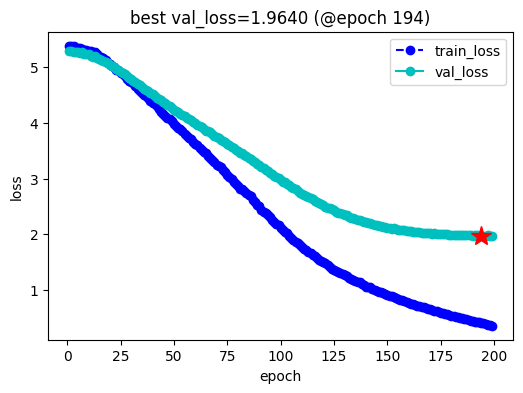

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,1,5.382812,0.000002,5.286493
1,2,5.371094,0.000002,5.292051
2,3,5.371094,0.000002,5.270239
3,4,5.339844,0.000002,5.277685
4,5,5.347656,0.000002,5.262898
...,...,...,...,...
194,195,0.398315,0.000002,1.977323
195,196,0.387695,0.000002,1.975553
196,197,0.374084,0.000002,1.982461
197,198,0.376282,0.000002,1.970847


In [19]:
#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint.pt'):
    self.net = self.net.from_pretrained(self.net,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = DATASET


keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=300,patience=5,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path,
                #mixed_precision='fp16'
               )

In [17]:
from peft import PeftModel
from transformers import  AutoModel,AutoTokenizer
DEVICE = 'cuda:3'
DATASET = 'eprstmt'
model_path = '../models/chatglm2/'
path_to_data = '/workspace/ChatGLM2_test/data/demo1'
ckpt_path = DATASET
model = AutoModel.from_pretrained(model_path,
                                  load_in_8bit=False,
                                  trust_remote_code=True).cuda(DEVICE)
model = PeftModel.from_pretrained(model,ckpt_path)
model = model.merge_and_unload() #合并lora权重

Loading checkpoint shards: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


In [18]:
def predict(text):
    response, history = model.chat(tokenizer, f"{text} -> ", history=his,
    temperature=0.01)
    return response 
predict('好用')

'好评'

In [19]:
len(test['label'])

610

In [20]:
preds = ['' for x in test['label']]

from tqdm import tqdm 
for i in tqdm(range(len(test['label']))):
    text = test['text'][i]
    preds[i] = predict(text)

100%|██████████| 610/610 [01:55<00:00,  5.28it/s]


In [21]:
Counter(preds)

Counter({'差评': 350, '好评': 258, '中规中矩': 1, '中肯好评': 1})

In [22]:
count = 0
for i,j in zip(preds,test['label']):
    if i == j:
        count+=1
print(count/len(test['label']))

0.8885245901639345


In [23]:
# 0.9

: 